This notebook provides аn example of Hull-White Model

✅ Калиброванные параметры: a = 0.0010, sigma = 0.0100


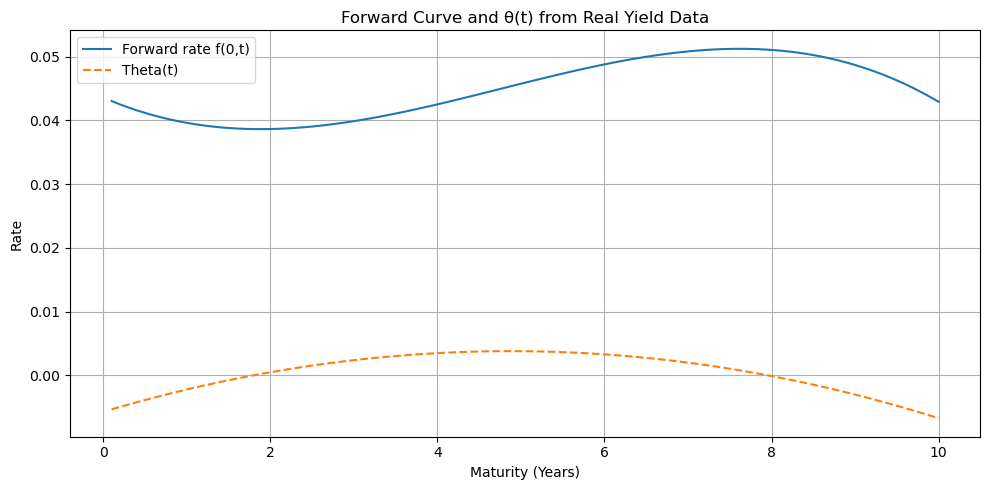


📊 Сравнение цен ZCB:
1Y: Market = 0.959541, Model = 0.959561, Diff = 1.980813e-05
2Y: Market = 0.922932, Model = 0.920795, Diff = -2.136376e-03
5Y: Market = 0.815055, Model = 0.813846, Diff = -1.209140e-03
10Y: Market = 0.638266, Model = 0.663025, Diff = 2.475938e-02


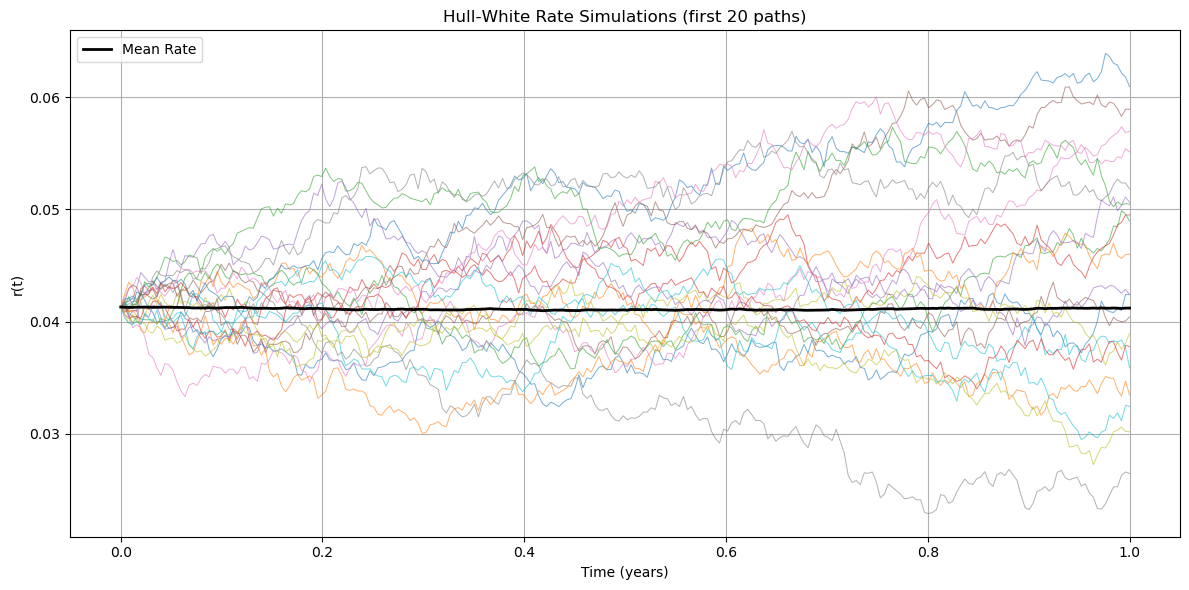

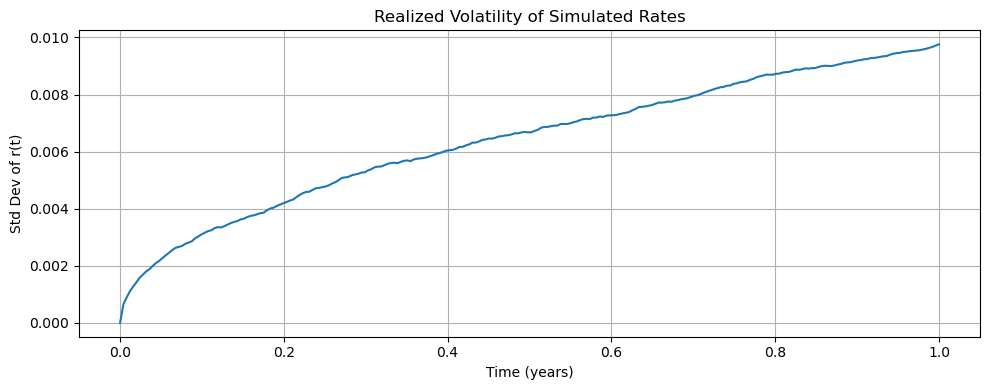

📈 Сигнал от симуляции ставок: 0 (1=long, -1=short, 0=neutral)
→ r0 = 0.0413, mean = 0.0412, std = 0.0098

📊 Стратегия на основе Hull-White симуляции:
Sharpe: nan
Max Drawdown: 0.00%


C:\Users\Admin\AppData\Local\Temp\ipykernel_18428\696766697.py:197: RuntimeWarning: invalid value encountered in scalar divide
  sim_sharpe = sim_strategy.mean() / sim_strategy.std() * np.sqrt(252)


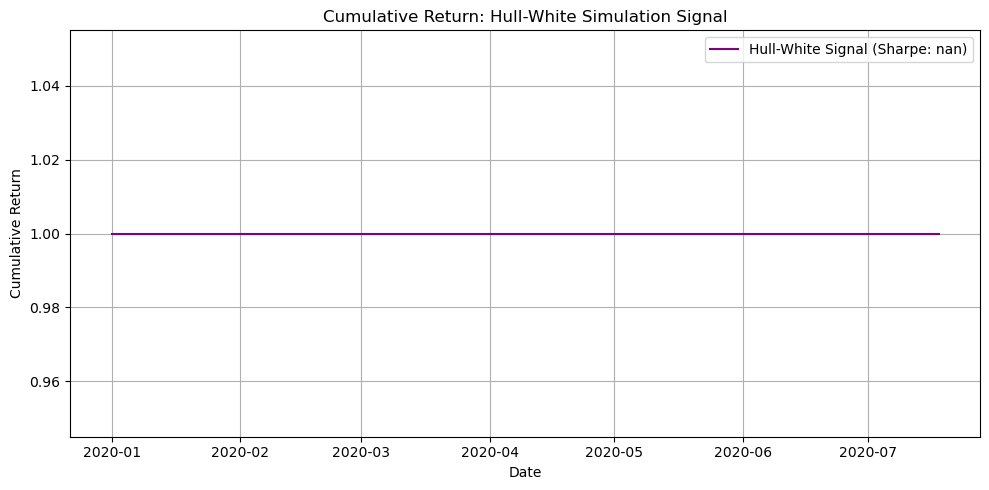


📈 Summary Table:
      Strategy    Sharpe  Max Drawdown      CAGR
             a -1.832418     -0.022074 -0.018074
             σ -0.512079     -0.014862 -0.006736
      combined -1.155680     -0.018329 -0.015268
simulated (HW)       NaN      0.000000  0.000000


C:\Users\Admin\AppData\Local\Temp\ipykernel_18428\696766697.py:228: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = series.mean() / series.std() * np.sqrt(252)


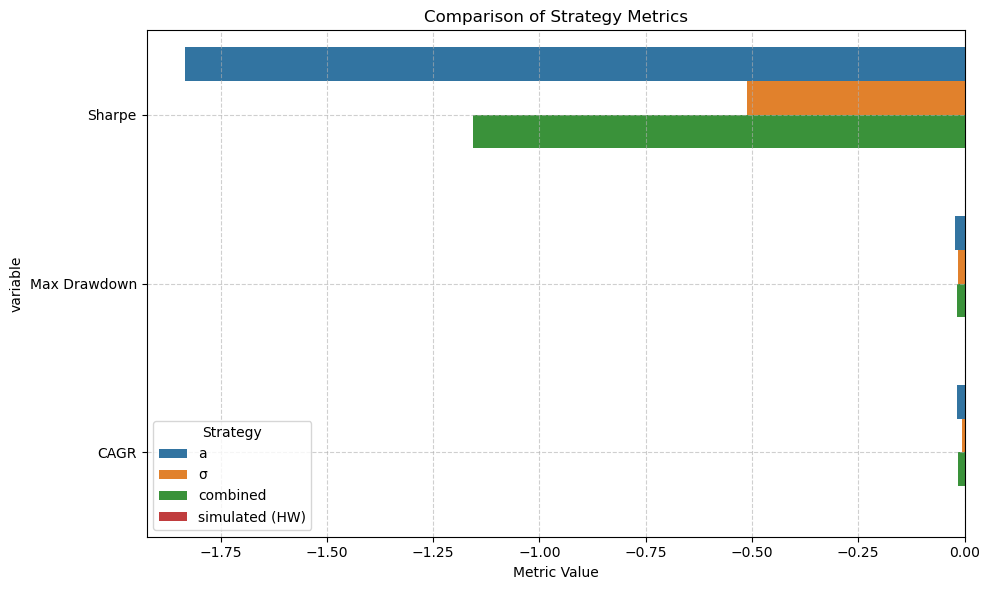

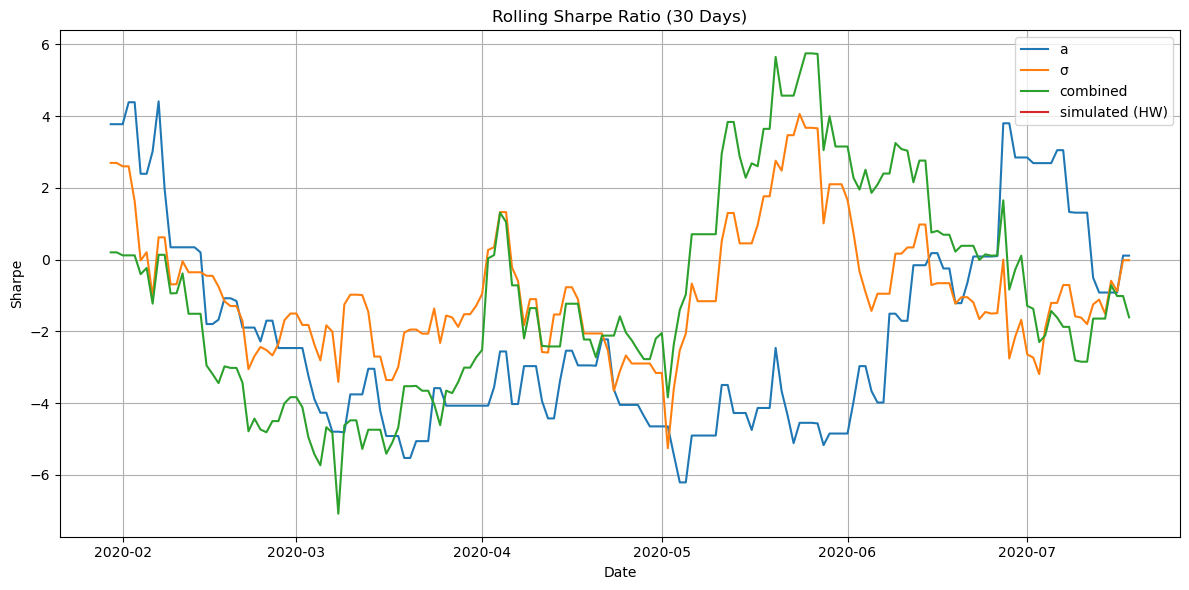

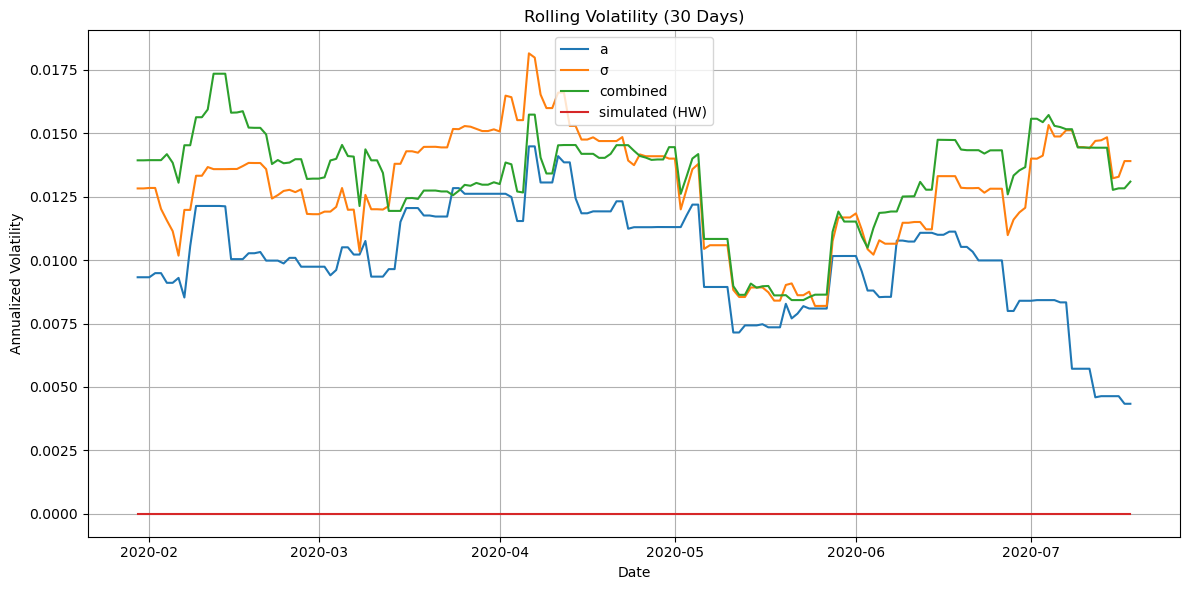

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


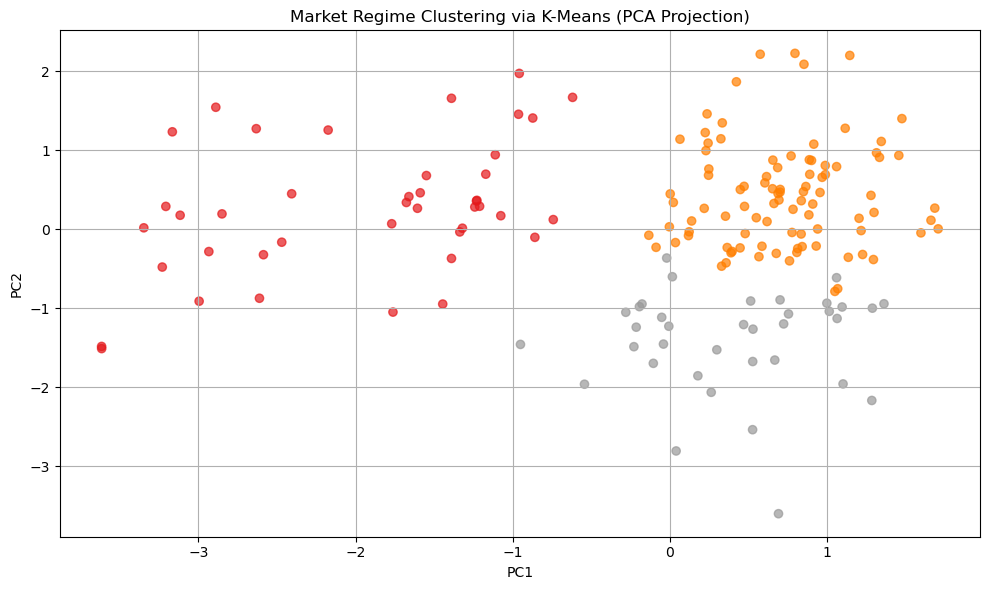

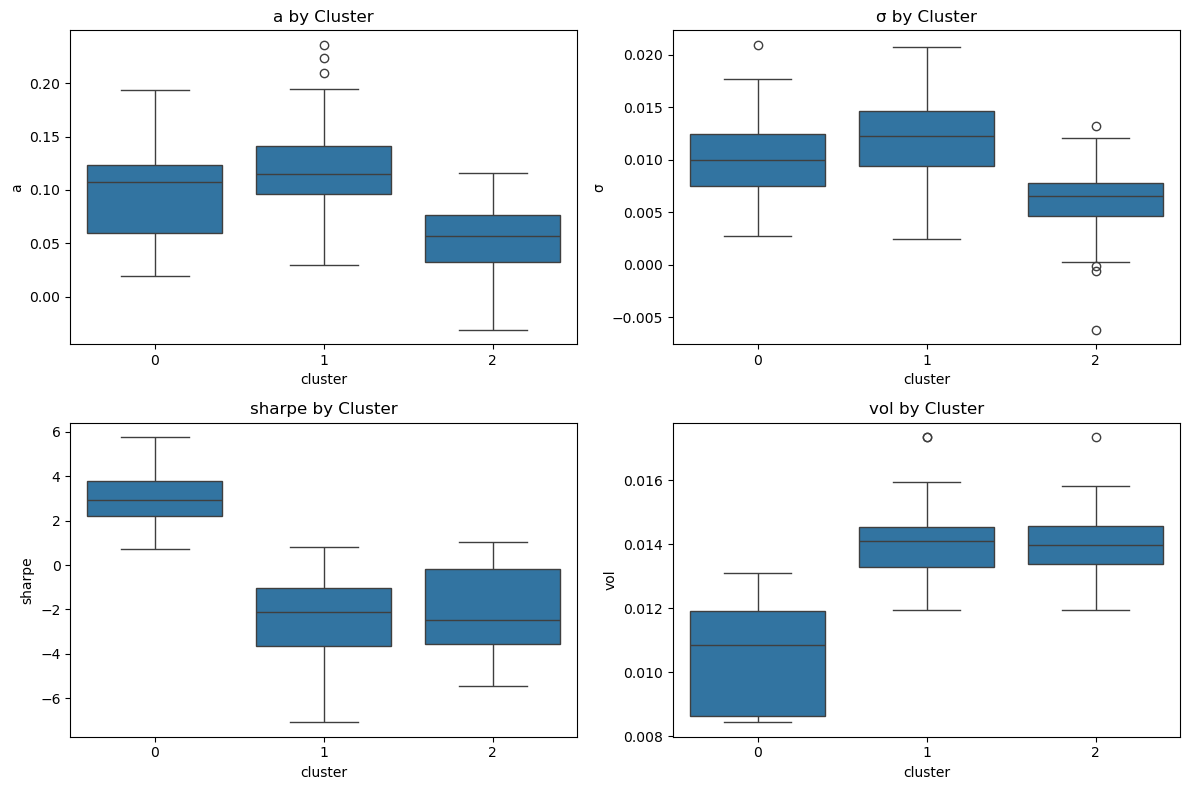

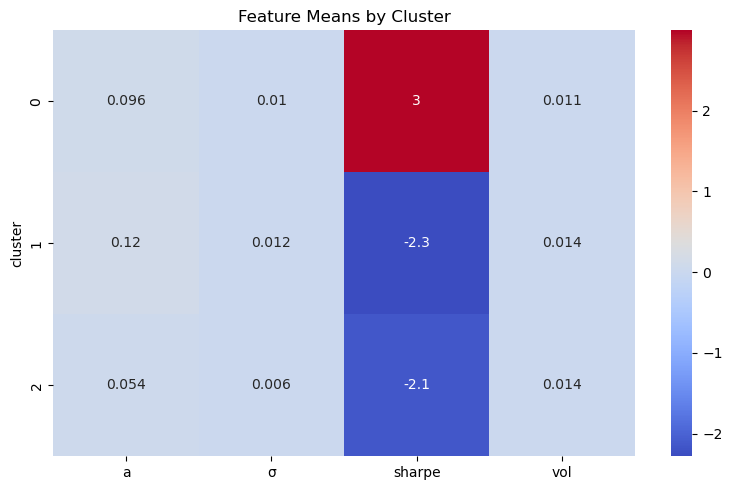


📂 Number of observations per cluster:
 cluster
0    42
1    93
2    36
Name: count, dtype: int64

📈 Strategy returns stats per cluster:
              mean       std  count
cluster                           
0        0.000073  0.000704     42
1       -0.000092  0.000830     93
2       -0.000200  0.000936     36


In [17]:
# Hull-White Model: Interest Rate Simulation and Applications

# Full combined version with all sections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.graphics.tsaplots import plot_acf
import calendar
import yfinance as yf

# Load historical yield data (example: 1Y, 2Y, 5Y, 10Y)
# 📡 Load real yield curve data from FRED
from fredapi import Fred
fred = Fred(api_key='c5eac556c7033d633c25a91225cea21c')  # Замените на свой API-ключ с сайта FRED

# Загрузка исторических ставок: 1Y, 2Y, 5Y, 10Y
series = {
    '1Y': 'DGS1',
    '2Y': 'DGS2',
    '5Y': 'DGS5',
    '10Y': 'DGS10'
}
yield_data = pd.DataFrame({label: fred.get_series(code) for label, code in series.items()})
yield_data.index = pd.to_datetime(yield_data.index)
yield_data = yield_data.dropna()
yield_data = yield_data / 100  # convert from % to decimal

# Интерполяция кривой доходности
maturities = np.array([1, 2, 5, 10])
latest_yields = yield_data.iloc[-1].values  # уже в долях
interp_yield = interp1d(maturities, latest_yields, kind='cubic', fill_value='extrapolate')

# 📐 Аналитическая цена zero-coupon облигации через Hull-White

# Функции B(t,T) и A(t,T)
def B_hw(a, t, T):
    return (1 - np.exp(-a * (T - t))) / a

def A_hw(a, sigma, t, T):
    B = B_hw(a, t, T)
    part1 = sigma**2 / (4 * a) * (1 - np.exp(-2 * a * t)) * B**2
    return np.exp(part1)

# Цена облигации в Hull-White
def P_HW(t, T, r_t, a, sigma):
    B = B_hw(a, t, T)
    A = A_hw(a, sigma, t, T)
    return A * np.exp(-B * r_t)

# Пример расчёта рыночных цен ZCB
T_list = [1, 2, 5, 10]
market_prices = [np.exp(-y * T) for y, T in zip(latest_yields, T_list)]
r_t = latest_yields[0]  # текущая краткосрочная ставка

# Калибровка параметров модели по ценам ZCB
def calibration_objective(params):
    a, sigma = params
    total_error = 0.0
    for T, market_price in zip(T_list, market_prices):
        model_price = P_HW(0, T, r_t, a, sigma)
        total_error += (market_price - model_price) ** 2
    return total_error

res = minimize(calibration_objective, [0.1, 0.01], bounds=[(0.001, 1), (0.0001, 0.05)])
a_calib, sigma_calib = res.x
print(f"✅ Калиброванные параметры: a = {a_calib:.4f}, sigma = {sigma_calib:.4f}")

# Построение zero-coupon price curve: P(0, t) = exp(-y(t) * t)
def zero_price(t):
    y = interp_yield(t)
    return np.exp(-y * t)

# Форвардная ставка: f(0, t) ≈ -d ln P(0,t) / dt
def forward_rate(t, eps=1e-4):
    return -(np.log(zero_price(t + eps)) - np.log(zero_price(t))) / eps

# Функция θ(t) в Hull-White модели
def theta_hw(t, a, sigma):
    fwd = forward_rate(t)
    dfdt = (forward_rate(t + 1e-4) - forward_rate(t)) / 1e-4
    term3 = sigma**2 / (2 * a) * (1 - np.exp(-2 * a * t))
    return a * fwd + dfdt + term3

# Визуализация форвардной кривой и theta
t_grid = np.linspace(0.1, 10, 100)
f_grid = [forward_rate(t) for t in t_grid]
theta_grid = [theta_hw(t, a_calib, sigma_calib) for t in t_grid]

plt.figure(figsize=(10, 5))
plt.plot(t_grid, f_grid, label="Forward rate f(0,t)")
plt.plot(t_grid, theta_grid, label="Theta(t)", linestyle='--')
plt.title("Forward Curve and θ(t) from Real Yield Data")
plt.xlabel("Maturity (Years)")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Сравнение цен ZCB
model_prices = [P_HW(0, T, r_t, a_calib, sigma_calib) for T in T_list]
print("\n📊 Сравнение цен ZCB:")
for T, mkt, mdl in zip(T_list, market_prices, model_prices):
    diff = mdl - mkt
    print(f"{T}Y: Market = {mkt:.6f}, Model = {mdl:.6f}, Diff = {diff:.6e}")

# Симуляция Hull-White с реальной θ(t)

def simulate_hull_white_hw(a, sigma, r0, T, dt, n_paths):
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps))
    theta_vals = np.zeros(n_steps)
    times = np.linspace(0, T, n_steps)

    # Предвычислим θ на каждом шаге
    for i, t in enumerate(times):
        theta_vals[i] = theta_hw(t, a, sigma)
    rates[:, 0] = r0

    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt), n_paths)
        dr = a * (theta_vals[i] - rates[:, i-1]) * dt + sigma * dW
        rates[:, i] = rates[:, i-1] + dr

    return times, rates

# Параметры симуляции
T = 1.0      # 1 год
dt = 1/252   # шаг — 1 торговый день
n_paths = 1000
r0 = latest_yields[0]  # текущее значение краткосрочной ставки

times, sim_rates = simulate_hull_white_hw(a_calib, sigma_calib, r0, T, dt, n_paths)

# Визуализация: несколько траекторий + средняя
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.plot(times, sim_rates[i], lw=0.7, alpha=0.6)
plt.plot(times, sim_rates.mean(axis=0), color='black', lw=2, label='Mean Rate')
plt.title("Hull‑White Rate Simulations (first 20 paths)")
plt.xlabel("Time (years)")
plt.ylabel("r(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Анализ: реализованная волатильность - std rate across paths
realized_vol = sim_rates.std(axis=0)
plt.figure(figsize=(10, 4))
plt.plot(times, realized_vol)
plt.title("Realized Volatility of Simulated Rates")
plt.xlabel("Time (years)")
plt.ylabel("Std Dev of r(t)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Генерация сигнала на основе симуляции ставок
# Сигнал: если текущая ставка выше средней по траектории — шорт, иначе — лонг

# Берем последние значения для каждого пути
final_rates = sim_rates[:, -1]
mean_final = np.mean(final_rates)
std_final = np.std(final_rates)

# Используем стратегию по отклонению от среднего
# Например: если r0 > mean_final + std — short
#           если r0 < mean_final - std — long
#           иначе — flat

if r0 > mean_final + std_final:
    sim_signal = -1
elif r0 < mean_final - std_final:
    sim_signal = 1
else:
    sim_signal = 0

print(f"📈 Сигнал от симуляции ставок: {sim_signal} (1=long, -1=short, 0=neutral)")
print(f"→ r0 = {r0:.4f}, mean = {mean_final:.4f}, std = {std_final:.4f}")

# Создаём позицию: симуляция фиксирует один сигнал на весь период
sim_position = pd.Series(sim_signal, index=rolling_dates)

# Доходность стратегии на основе сигнала
sim_strategy = sim_position.shift(1).fillna(0) * strategy_returns
sim_cumulative = (1 + sim_strategy).cumprod()

# Метрики
sim_sharpe = sim_strategy.mean() / sim_strategy.std() * np.sqrt(252)
sim_drawdown = (sim_cumulative - sim_cumulative.cummax()).min()

# Вывод
print(f"\n📊 Стратегия на основе Hull-White симуляции:")
print(f"Sharpe: {sim_sharpe:.2f}")
print(f"Max Drawdown: {sim_drawdown:.2%}")

# График
plt.figure(figsize=(10, 5))
plt.plot(sim_cumulative, label=f'Hull-White Signal (Sharpe: {sim_sharpe:.2f})', color='purple')
plt.title("Cumulative Return: Hull-White Simulation Signal")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Все стратегии
strategies = {
    "a": strat_a,
    "σ": strat_sigma,
    "combined": strat_comb,
    "simulated (HW)": sim_strategy
}

# Расчёт метрик
summary = []
for name, series in strategies.items():
    cumulative = (1 + series).cumprod()
    sharpe = series.mean() / series.std() * np.sqrt(252)
    drawdown = (cumulative - cumulative.cummax()).min()
    cagr = (cumulative.iloc[-1])**(252 / len(series)) - 1
    summary.append([name, sharpe, drawdown, cagr])

metrics_summary_df = pd.DataFrame(summary, columns=["Strategy", "Sharpe", "Max Drawdown", "CAGR"])

# Вывод
print("\n📈 Summary Table:")
print(metrics_summary_df.to_string(index=False))

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_summary_df.melt(id_vars='Strategy'), x='value', y='variable', hue='Strategy', orient='h')
plt.title("Comparison of Strategy Metrics")
plt.xlabel("Metric Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Rolling анализ: Sharpe и std по окну
window = 30
rolling_metrics = {}
for name, series in strategies.items():
    rolling_sharpe = series.rolling(window).mean() / series.rolling(window).std() * np.sqrt(252)
    rolling_vol = series.rolling(window).std() * np.sqrt(252)
    rolling_metrics[name] = {
        "sharpe": rolling_sharpe,
        "volatility": rolling_vol
    }

# Визуализация Sharpe
plt.figure(figsize=(12, 6))
for name in strategies:
    plt.plot(rolling_metrics[name]["sharpe"], label=f"{name}")
plt.title("Rolling Sharpe Ratio (30 Days)")
plt.xlabel("Date")
plt.ylabel("Sharpe")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Визуализация Volatility
plt.figure(figsize=(12, 6))
for name in strategies:
    plt.plot(rolling_metrics[name]["volatility"], label=f"{name}")
plt.title("Rolling Volatility (30 Days)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Подготовка данных для кластеризации
features = pd.DataFrame({
    "a": rolling_a,
    "σ": rolling_sigma,
    "sharpe": rolling_sharpe_comb,
    "vol": strat_comb.rolling(30).std() * np.sqrt(252)
}).dropna()

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA (для визуализации)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Визуализация кластеров
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set1', alpha=0.7)
plt.title("Market Regime Clustering via K-Means (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Добавим кластеры в датафрейм
features["cluster"] = labels

# 11. Анализ по кластерам

# 1. Boxplot признаков по кластерам
plt.figure(figsize=(12, 8))
for i, col in enumerate(["a", "σ", "sharpe", "vol"]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x="cluster", y=col, data=features)
    plt.title(f"{col} by Cluster")
plt.tight_layout()
plt.show()

# 2. Heatmap — средние значения признаков по кластерам
cluster_means = features.groupby("cluster").mean()
plt.figure(figsize=(8, 5))
sns.heatmap(cluster_means, annot=True, cmap="coolwarm")
plt.title("Feature Means by Cluster")
plt.tight_layout()
plt.show()

# 3. Подсчёт размеров кластеров
counts = features["cluster"].value_counts().sort_index()
print("\n📂 Number of observations per cluster:\n", counts)

# 4. Сравнение доходности стратегии в разных режимах
# (допустим strat_comb смещён по rolling.date, вытянем индексы)
strat_comb_aligned = strat_comb.loc[features.index]
returns_by_cluster = strat_comb_aligned.groupby(features["cluster"]).agg(['mean', 'std', 'count'])
print("\n📈 Strategy returns stats per cluster:\n", returns_by_cluster)


# Остальные блоки остаются без изменений дальше…
